<a href="https://colab.research.google.com/github/gkiflex/MSAI-630-A01/blob/master/energy_based_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preprocessing MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample training images:


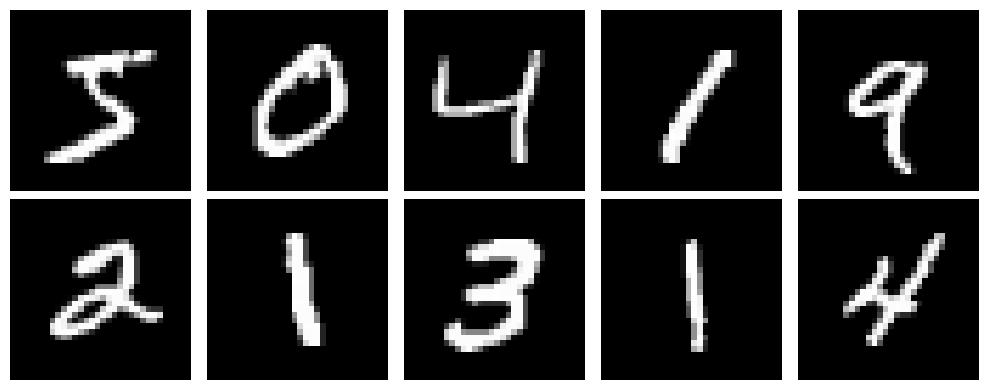

Building EBM network...
Energy model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

Setting up EBM for training...
Starting training for 120 epochs...
Training with contrastive divergence algorithm...
Epoch 1/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -0.0515 - fake: 0.2175 - loss: -0.0322 - real: 0.2691 - reg: 0.0193

ValueError: The filename must end in `.weights.h5`. Received: filepath=./models/ebm_model.h5

In [1]:
# Energy-Based Models (EBM) Training Script for Google Colab
# Adapted for MNIST dataset with 120 epochs training

import numpy as np
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

# Create output directories
os.makedirs('./output', exist_ok=True)
os.makedirs('./models', exist_ok=True)

# =============================================================================
# PARAMETERS
# =============================================================================
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 120  # Updated to 120 epochs as requested
LOAD_MODEL = False

# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
print("Loading and preprocessing MNIST data...")

# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Create datasets
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

# Display function for visualization
def display(images, save_to=None):
    """Display a batch of images in a grid"""
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            # Denormalize for display
            img = (images[i].squeeze() + 1) / 2
            ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight', dpi=150)
    plt.show()

# Show some samples from training data
print("Sample training images:")
sample_batch = next(iter(x_train))
display(sample_batch[:10].numpy())

# =============================================================================
# EBM NETWORK ARCHITECTURE
# =============================================================================
print("Building EBM network...")

# Build the energy function network
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)  # Energy output

energy_model = models.Model(ebm_input, ebm_output)
print("Energy model architecture:")
energy_model.summary()

# =============================================================================
# LANGEVIN SAMPLER
# =============================================================================
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    """
    Generate samples using Langevin Dynamics
    """
    imgs_per_step = []

    for step in range(steps):
        # Add noise
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

        # Compute gradients
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)

        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)

        # Update images using gradient ascent (maximize energy)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

        if return_img_per_step:
            imgs_per_step.append(tf.identity(inp_imgs))

    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

# =============================================================================
# SAMPLE BUFFER
# =============================================================================
class Buffer:
    """Buffer to store negative samples for persistent contrastive divergence"""

    def __init__(self, model):
        super().__init__()
        self.model = model
        # Initialize buffer with random samples
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        """Sample new negative examples using persistent contrastive divergence"""
        # Mix of new random samples (5%) and buffer samples (95%)
        n_new = np.random.binomial(BATCH_SIZE, 0.05)

        # Generate new random samples
        rand_imgs = tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

        # Sample from buffer
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )

        # Combine new and old samples
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)

        # Run Langevin dynamics
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )

        # Update buffer
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]

        return inp_imgs

# =============================================================================
# CUSTOM EBM MODEL WITH CONTRASTIVE DIVERGENCE
# =============================================================================
class EBM(models.Model):
    """Energy-Based Model with Contrastive Divergence training"""

    def __init__(self):
        super(EBM, self).__init__()
        self.model = energy_model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA

        # Metrics for monitoring training
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        """Training step implementing contrastive divergence"""

        # Add small noise to real images
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean=0, stddev=NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)

        # Sample negative examples from buffer
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )

        # Combine real and fake images
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        # Forward pass and loss computation
        with tf.GradientTape() as training_tape:
            energy_outputs = self.model(inp_imgs)
            real_out, fake_out = tf.split(energy_outputs, 2, axis=0)

            # Contrastive divergence loss
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)

            # Regularization loss to prevent energy from growing too large
            reg_loss = self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)

            # Total loss
            loss = cdiv_loss + reg_loss

        # Compute and apply gradients
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Update metrics
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        """Test step for validation"""
        batch_size = real_imgs.shape[0]

        # Generate random fake images for testing
        fake_imgs = tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

        # Combine and evaluate
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        energy_outputs = self.model(inp_imgs)
        real_out, fake_out = tf.split(energy_outputs, 2, axis=0)

        # Compute contrastive divergence for validation
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)

        # Update metrics
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics[2:]}

# =============================================================================
# CALLBACKS
# =============================================================================
class ImageGenerator(callbacks.Callback):
    """Callback to generate and display images during training"""

    def __init__(self, num_img=10):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Generate images every 10 epochs
            print(f"\nGenerating images at epoch {epoch}...")

            # Generate images from random noise
            start_imgs = np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            ) * 2 - 1

            generated_images = generate_samples(
                self.model.model,
                start_imgs,
                steps=1000,
                step_size=STEP_SIZE,
                noise=NOISE,
                return_img_per_step=False,
            )

            print("Generated images:")
            display(
                generated_images.numpy(),
                save_to=f"./output/generated_img_{epoch:03d}.png"
            )

            # Display some buffer examples
            if len(self.model.buffer.examples) >= 10:
                example_images = tf.concat(
                    random.choices(self.model.buffer.examples, k=10), axis=0
                )
                print("Buffer examples:")
                display(
                    example_images.numpy(),
                    save_to=f"./output/buffer_img_{epoch:03d}.png"
                )

class SaveModel(callbacks.Callback):
    """Callback to save model weights"""

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0 or epoch == EPOCHS - 1:  # Save every 20 epochs
            self.model.model.save_weights("./models/ebm_model.h5")
            print(f"Model saved at epoch {epoch}")

# =============================================================================
# TRAINING
# =============================================================================
print("Setting up EBM for training...")

# Create EBM instance
ebm = EBM()

# Compile model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    run_eagerly=True
)

# Setup callbacks
image_generator_callback = ImageGenerator(num_img=10)
save_model_callback = SaveModel()

print(f"Starting training for {EPOCHS} epochs...")
print("Training with contrastive divergence algorithm...")

# Train the model
history = ebm.fit(
    x_train,
    shuffle=True,
    epochs=EPOCHS,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        image_generator_callback,
    ],
    verbose=1
)

# =============================================================================
# FINAL GENERATION AND VISUALIZATION
# =============================================================================
print("\nTraining completed! Generating final samples...")

# Generate final samples
start_imgs = np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

print("Initial random noise:")
display(start_imgs)

# Generate with step-by-step visualization
print("Generating samples with Langevin dynamics...")
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

print("Final generated samples:")
display(gen_img[-1].numpy())

# Show progression for one sample
print("Generation progression for one sample:")
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[0])  # Take first sample

display(np.array(imgs))

# =============================================================================
# TRAINING HISTORY VISUALIZATION
# =============================================================================
print("Training history:")

# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics_to_plot = ['loss', 'cdiv', 'real', 'fake']
for i, metric in enumerate(metrics_to_plot):
    if metric in history.history:
        axes[i].plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[i].set_title(f'{metric.capitalize()} over epochs')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

plt.tight_layout()
plt.savefig('./output/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("EBM training completed successfully!")
print(f"Model weights saved to: ./models/ebm_model.h5")
print(f"Generated images saved to: ./output/")

Loading and preprocessing MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample training images:


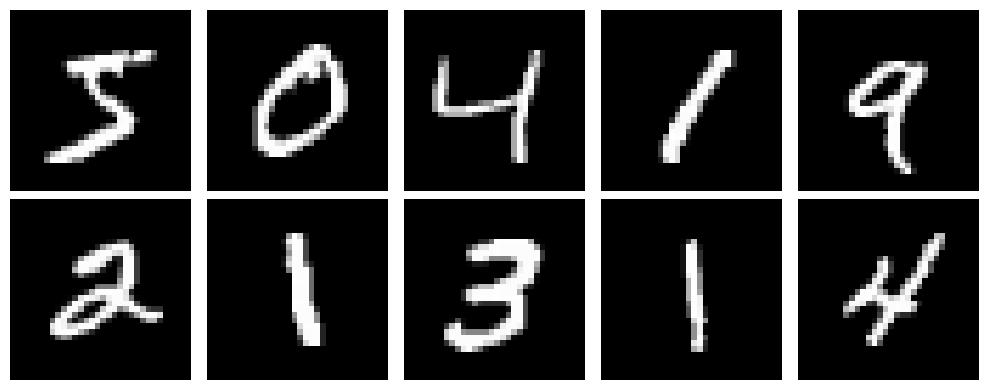

Building EBM network...
Energy model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

Setting up EBM for training...
Starting training for 120 epochs...
Training with contrastive divergence algorithm...
Epoch 1/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -0.0592 - fake: 0.2186 - loss: -0.0391 - real: 0.2778 - reg: 0.0201Model saved at epoch 0

Generating images at epoch 0...
Generated images:


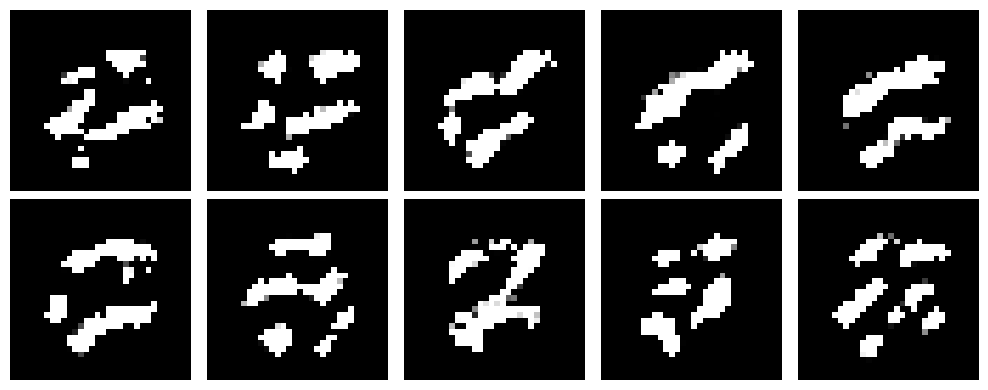

Buffer examples:


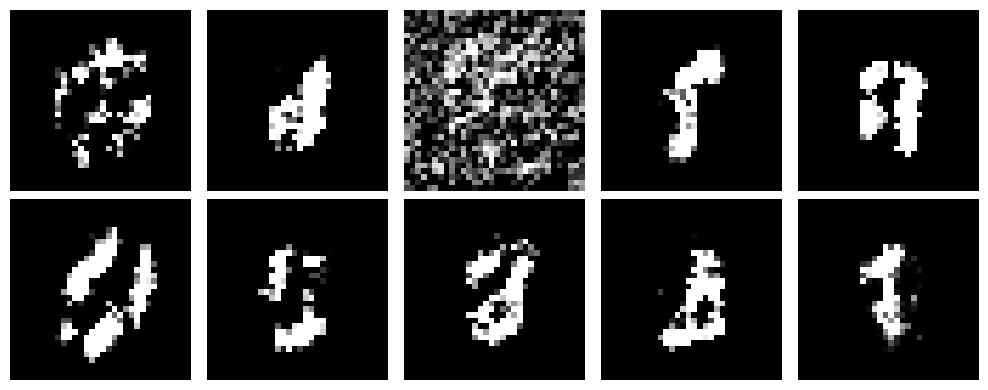

469/469 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - cdiv: -0.0592 - fake: 0.2185 - loss: -0.0391 - real: 0.2776 - reg: 0.0201 - val_cdiv: -1.4619 - val_fake: -1.5241 - val_real: -0.0622
Epoch 2/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 781s 2s/step - cdiv: -0.0104 - fake: 0.0148 - loss: -0.0068 - real: 0.0252 - reg: 0.0037 - val_cdiv: -1.9799 - val_fake: -1.9971 - val_real: -0.0172
Epoch 3/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 761s 2s/step - cdiv: -0.0029 - fake: 0.0043 - loss: -0.0014 - real: 0.0072 - reg: 0.0015 - val_cdiv: -2.2918 - val_fake: -2.3083 - val_real: -0.0165
Epoch 4/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - cdiv: -9.2176e-04 - fake: 0.0034 - loss: -1.0538e-04 - real: 0.0043 - reg: 8.1638e-04 - val_cdiv: -2.6610 - val_fake: -2.6854 - val_real: -0.0244
Epoch 5/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - cdiv: 5.3217e-04 - fake: 0.0024 - loss: 0.0010 - real: 0.0019 - reg: 5.0568e-04 - val_cdiv: -2.9360 - val_fake: -2.9559 - val_real: -0.0198
Epoch 6/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 748

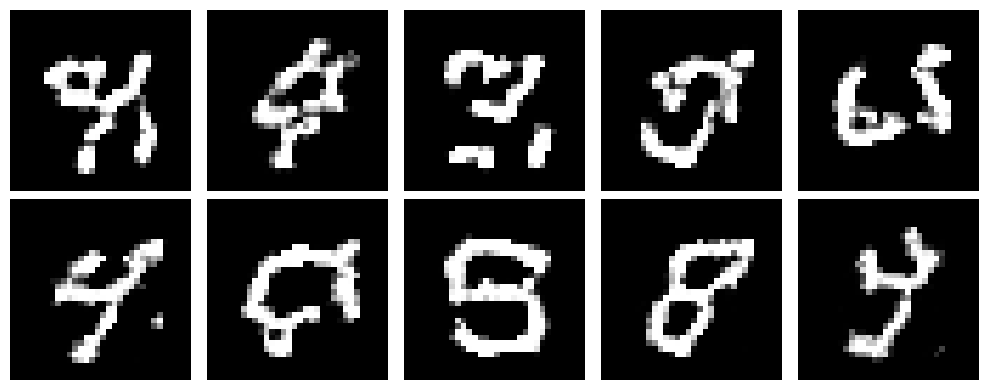

Buffer examples:


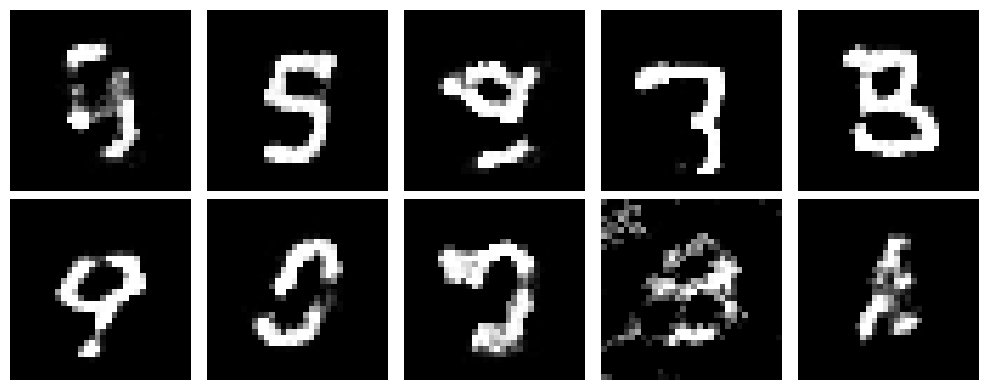

469/469 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - cdiv: -7.7173e-04 - fake: -0.0017 - loss: -2.8721e-04 - real: -9.5892e-04 - reg: 4.8452e-04 - val_cdiv: -4.9300 - val_fake: -4.9071 - val_real: 0.0229
Epoch 12/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - cdiv: -5.1031e-04 - fake: -0.0019 - loss: -2.7012e-05 - real: -0.0014 - reg: 4.8329e-04 - val_cdiv: -5.3217 - val_fake: -5.2708 - val_real: 0.0509
Epoch 13/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - cdiv: -0.0012 - fake: -0.0019 - loss: -6.5293e-04 - real: -7.3517e-04 - reg: 5.5185e-04 - val_cdiv: -5.8494 - val_fake: -5.7713 - val_real: 0.0781
Epoch 14/120
469/469 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - cdiv: -5.5037e-04 - fake: -4.9944e-04 - loss: 1.0678e-05 - real: 5.0925e-05 - reg: 5.6105e-04 - val_cdiv: -6.0050 - val_fake: -5.9661 - val_real: 0.0389
Epoch 15/120
393/469 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - cdiv: -0.0010 - fake: 2.7233e-04 - loss: -5.9137e-04 - real: 0.0013 - reg: 4.2596e-04

In [ ]:
# Energy-Based Models (EBM) Training Script for Google Colab
# Adapted for MNIST dataset with 120 epochs training

import numpy as np
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

# Create output directories
os.makedirs('./output', exist_ok=True)
os.makedirs('./models', exist_ok=True)

# =============================================================================
# PARAMETERS
# =============================================================================
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 120  # Updated to 120 epochs as requested
LOAD_MODEL = False

# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
print("Loading and preprocessing MNIST data...")

# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Create datasets
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

# Display function for visualization
def display(images, save_to=None):
    """Display a batch of images in a grid"""
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            # Denormalize for display
            img = (images[i].squeeze() + 1) / 2
            ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight', dpi=150)
    plt.show()

# Show some samples from training data
print("Sample training images:")
sample_batch = next(iter(x_train))
display(sample_batch[:10].numpy())

# =============================================================================
# EBM NETWORK ARCHITECTURE
# =============================================================================
print("Building EBM network...")

# Build the energy function network
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)  # Energy output

energy_model = models.Model(ebm_input, ebm_output)
print("Energy model architecture:")
energy_model.summary()

# =============================================================================
# LANGEVIN SAMPLER
# =============================================================================
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    """
    Generate samples using Langevin Dynamics
    """
    imgs_per_step = []

    for step in range(steps):
        # Add noise
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

        # Compute gradients
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)

        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)

        # Update images using gradient ascent (maximize energy)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)

        if return_img_per_step:
            imgs_per_step.append(tf.identity(inp_imgs))

    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

# =============================================================================
# SAMPLE BUFFER
# =============================================================================
class Buffer:
    """Buffer to store negative samples for persistent contrastive divergence"""

    def __init__(self, model):
        super().__init__()
        self.model = model
        # Initialize buffer with random samples
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        """Sample new negative examples using persistent contrastive divergence"""
        # Mix of new random samples (5%) and buffer samples (95%)
        n_new = np.random.binomial(BATCH_SIZE, 0.05)

        # Generate new random samples
        rand_imgs = tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

        # Sample from buffer
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )

        # Combine new and old samples
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)

        # Run Langevin dynamics
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )

        # Update buffer
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]

        return inp_imgs

# =============================================================================
# CUSTOM EBM MODEL WITH CONTRASTIVE DIVERGENCE
# =============================================================================
class EBM(models.Model):
    """Energy-Based Model with Contrastive Divergence training"""

    def __init__(self):
        super(EBM, self).__init__()
        self.model = energy_model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA

        # Metrics for monitoring training
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        """Training step implementing contrastive divergence"""

        # Add small noise to real images
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean=0, stddev=NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)

        # Sample negative examples from buffer
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )

        # Combine real and fake images
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        # Forward pass and loss computation
        with tf.GradientTape() as training_tape:
            energy_outputs = self.model(inp_imgs)
            real_out, fake_out = tf.split(energy_outputs, 2, axis=0)

            # Contrastive divergence loss
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)

            # Regularization loss to prevent energy from growing too large
            reg_loss = self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)

            # Total loss
            loss = cdiv_loss + reg_loss

        # Compute and apply gradients
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Update metrics
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        """Test step for validation"""
        batch_size = real_imgs.shape[0]

        # Generate random fake images for testing
        fake_imgs = tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

        # Combine and evaluate
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        energy_outputs = self.model(inp_imgs)
        real_out, fake_out = tf.split(energy_outputs, 2, axis=0)

        # Compute contrastive divergence for validation
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)

        # Update metrics
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics[2:]}

# =============================================================================
# CALLBACKS
# =============================================================================
class ImageGenerator(callbacks.Callback):
    """Callback to generate and display images during training"""

    def __init__(self, num_img=10):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Generate images every 10 epochs
            print(f"\nGenerating images at epoch {epoch}...")

            # Generate images from random noise
            start_imgs = np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            ) * 2 - 1

            generated_images = generate_samples(
                self.model.model,
                start_imgs,
                steps=1000,
                step_size=STEP_SIZE,
                noise=NOISE,
                return_img_per_step=False,
            )

            print("Generated images:")
            display(
                generated_images.numpy(),
                save_to=f"./output/generated_img_{epoch:03d}.png"
            )

            # Display some buffer examples
            if len(self.model.buffer.examples) >= 10:
                example_images = tf.concat(
                    random.choices(self.model.buffer.examples, k=10), axis=0
                )
                print("Buffer examples:")
                display(
                    example_images.numpy(),
                    save_to=f"./output/buffer_img_{epoch:03d}.png"
                )

class SaveModel(callbacks.Callback):
    """Callback to save model weights"""

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0 or epoch == EPOCHS - 1:  # Save every 20 epochs
            self.model.model.save_weights("./models/ebm_model.weights.h5")
            print(f"Model saved at epoch {epoch}")

# =============================================================================
# TRAINING
# =============================================================================
print("Setting up EBM for training...")

# Create EBM instance
ebm = EBM()

# Compile model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    run_eagerly=True
)

# Setup callbacks
image_generator_callback = ImageGenerator(num_img=10)
save_model_callback = SaveModel()

print(f"Starting training for {EPOCHS} epochs...")
print("Training with contrastive divergence algorithm...")

# Train the model
history = ebm.fit(
    x_train,
    shuffle=True,
    epochs=EPOCHS,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        image_generator_callback,
    ],
    verbose=1
)

# =============================================================================
# FINAL GENERATION AND VISUALIZATION
# =============================================================================
print("\nTraining completed! Generating final samples...")

# Generate final samples
start_imgs = np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1

print("Initial random noise:")
display(start_imgs)

# Generate with step-by-step visualization
print("Generating samples with Langevin dynamics...")
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

print("Final generated samples:")
display(gen_img[-1].numpy())

# Show progression for one sample
print("Generation progression for one sample:")
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[0])  # Take first sample

display(np.array(imgs))

# =============================================================================
# TRAINING HISTORY VISUALIZATION
# =============================================================================
print("Training history:")

# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics_to_plot = ['loss', 'cdiv', 'real', 'fake']
for i, metric in enumerate(metrics_to_plot):
    if metric in history.history:
        axes[i].plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[i].set_title(f'{metric.capitalize()} over epochs')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

plt.tight_layout()
plt.savefig('./output/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("EBM training completed successfully!")
print(f"Model weights saved to: ./models/ebm_model.weights.h5")
print(f"Generated images saved to: ./output/")